In [4]:
suppressMessages(library(tidyverse))
suppressMessages(library(Seurat))
library(ggalluvial)
library(patchwork)
suppressMessages(library(kableExtra))
library(IRdisplay)
library(ggsci)

In [5]:
outputfiles=list.files('/mnt/MXMERZ002A/LargeData/enclone/', pattern = 'enclone_output', full.names = T)

In [6]:
results_list=lapply(outputfiles, read_csv, show_col_types = FALSE)

In [7]:
donor=sapply(results_list, function(x) x$donors[1])
results_list=results_list[order(donor)]

In [8]:
TCR_results_pcell=bind_rows(lapply(outputfiles, read_csv, show_col_types = FALSE))

In [9]:
TCR_results1=TCR_results_pcell %>% group_by(origins_cell) %>% mutate(origin_total=n()) %>% add_count(group_id, name='count') %>% 
mutate(percentage=count/origin_total*100) %>%filter(!is.na(cdr3_aa1)) %>%
distinct(donors, origins_cell, group_id, cdr3_aa1, v_name1, j_name1, origin_total, count, percentage)

In [20]:
plotalluvial=function(clone_counts_plot_long, facet_spacing=2, rotate=F, xaes='origins_cell', title=NA) {
    xaes=sym(xaes)
    if (is.na(title)){
        title=paste("Patient",clone_counts_plot_long$donors[1])
    }
    p=ggplot(clone_counts_plot_long,
       aes(x = !!xaes, stratum = group_id, alluvium = group_id,
           y = value,
           fill = group_id, label = group_id)) +
  scale_x_discrete(expand = c(.1, .1)) +
  geom_flow() +
  geom_stratum(alpha = .5) +
  #geom_text(stat = "stratum", size = 3) +
  guides(fill="none")+
    facet_wrap(~freq, scales="free_y")+
  ggtitle(title) +
    #scale_fill_manual(values = DiscretePalette(levels(clone_counts_plot_long$group_id))) +
 scale_color_manual(breaks =c('CMV', 'EBV'), values=c("#ff0000","#ff0000", "#ff0000"), na.value	 = "#000000")+
 ylab("")+
    theme(text = element_text(size = 18))  +xlab("")+ theme(plot.margin = margin(t = 0, r = 2, b = 0, l = 0, "cm"))+ theme(panel.spacing = unit(facet_spacing, "lines"))
    if (rotate){
    p=p+ theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
    }
    return(p)
}

In [11]:
prepareplot=function(TCR_results_pcell, xaes='origins_cell', top_n=5){

#TCR_results_pcell=cross_proj_6
#xaes='day_source'
#top_n=3
    TCRplot=TCR_results_pcell %>% group_by(!!sym(xaes)) %>% mutate(origin_total=n()) %>% add_count(group_id, name='count') %>% 
mutate(percentage=count/origin_total*100) %>%filter(!is.na(cdr3_aa1)) %>%
distinct(donors, !!sym(xaes), group_id, origin_total, count, percentage)

    newlevels= TCRplot %>% select(!!xaes) %>% distinct %>% unlist %>% str_sort(numeric = T)
    TCRplot = TCRplot %>% mutate({{xaes}}:=factor(!!sym(xaes), levels=newlevels))

#Select top clonotypes based on counts and percentages for each date of acquisition, then take union
clone_counts_grouped=TCRplot %>% group_by(!!sym(xaes))
top_per=clone_counts_grouped %>% arrange(-percentage) %>% slice_head(n=top_n) %>%ungroup %>% select(group_id) %>% unlist 
top_count=clone_counts_grouped %>% arrange(-count) %>% slice_head(n=top_n)%>%ungroup %>% select(group_id) %>% unlist 
top_overall=union(top_per, top_count) 

 TCRplot=TCRplot %>%
    filter(group_id %in% top_overall) %>%
pivot_longer(cols=count:percentage, names_to='freq') 

newlevels=str_sort(as.character(unique(TCRplot$group_id)), numeric=T)

TCRplot=TCRplot%>% mutate(group_id=factor(group_id, levels=newlevels)) 
}

# Investigation of TCRs
Alluvial plots of TCR clones between different time points. Numbers in the strata boxes are the clonotype id, and the ids are consistent within a patient across time points and cell types (BMMC and PBMC) A union of the top 5 clonotypes in terms of absolute counts and percentages at every time points are taken to be included in the plot. If there is no "flow" from a strata box, that means that particular clonotype is only detected at that time point and not detected at the other time point.

## Dara+CART dataset

In [1]:
library(xlsx)

In [12]:
metadata_excel=read.xlsx('/mnt/MXMERZ002A/LargeData/metadata.xlsx', sheetName='Sheet2')
metadata_excel=metadata_excel %>% select(barcode, collection.day) 

In [13]:
project2_metadata=read_csv('/mnt/MXMERZ002A/LargeData/seuratobjmetadata.csv', show_col_types = FALSE)
project2_metadata=project2_metadata %>% select(orig.ident, barcode, source, patient) %>% distinct
project2_metadata=project2_metadata %>% left_join(metadata_excel, by = "barcode") %>% select(!barcode) %>% 
mutate(collection.day=as.character(collection.day)) %>% mutate(Batch=2)

In [14]:
project1_metadata=readRDS('/mnt/MERZ001/LargeData/seuratobj.metadata.rds')
project1_metadata=project1_metadata %>% select(orig.ident, date.of.sample.acquisition, CellType, patient) %>% distinct %>%
mutate(patient=as.integer(str_extract(patient, '\\d$')))
project1_metadata=project1_metadata %>% mutate(CellType=ifelse(CellType=='PBMC', 'PB','BM'), patient=as.integer(patient))
project1_metadata=project1_metadata %>% select(orig.ident,	collection.day=date.of.sample.acquisition, source= CellType, patient) %>% mutate(Batch=1)

In [15]:
all_metadata=bind_rows(project2_metadata, project1_metadata) %>% remove_rownames

In [16]:
cross_proj_1=read_csv('/mnt/MXMERZ002A/LargeData/enclone/combinewithMERZ/enclone_output_1.csv', show_col_types = FALSE)

In [17]:
cross_proj_1=cross_proj_1 %>% left_join(all_metadata, by=c(origins_cell='orig.ident')) %>% 
unite(day_source, collection.day, source)

In [18]:
cross_proj_1_combined=prepareplot(cross_proj_1, xaes='day_source', top_n=3)
batch2=all_metadata %>% filter(patient==1, Batch==2) %>% unite(day_source, collection.day, source) %>% select(day_source) %>% unlist
bold.labels <- ifelse(levels(cross_proj_1_combined$day_source) %in% batch2, yes = "black", no = "#5A5A5A")

Patients 1 and 6 were included in the previous Dara dataset, so we tracked the clonotypes for these 2 patients across the previous and current datasets. The labels on the X axis is a concatenation of the date of sample collection and cell source. 
Labels in black are samples from the current set of samples (CAR-T treated), and labels in dark grey are samples from the previous set of samples (Dara treated). 

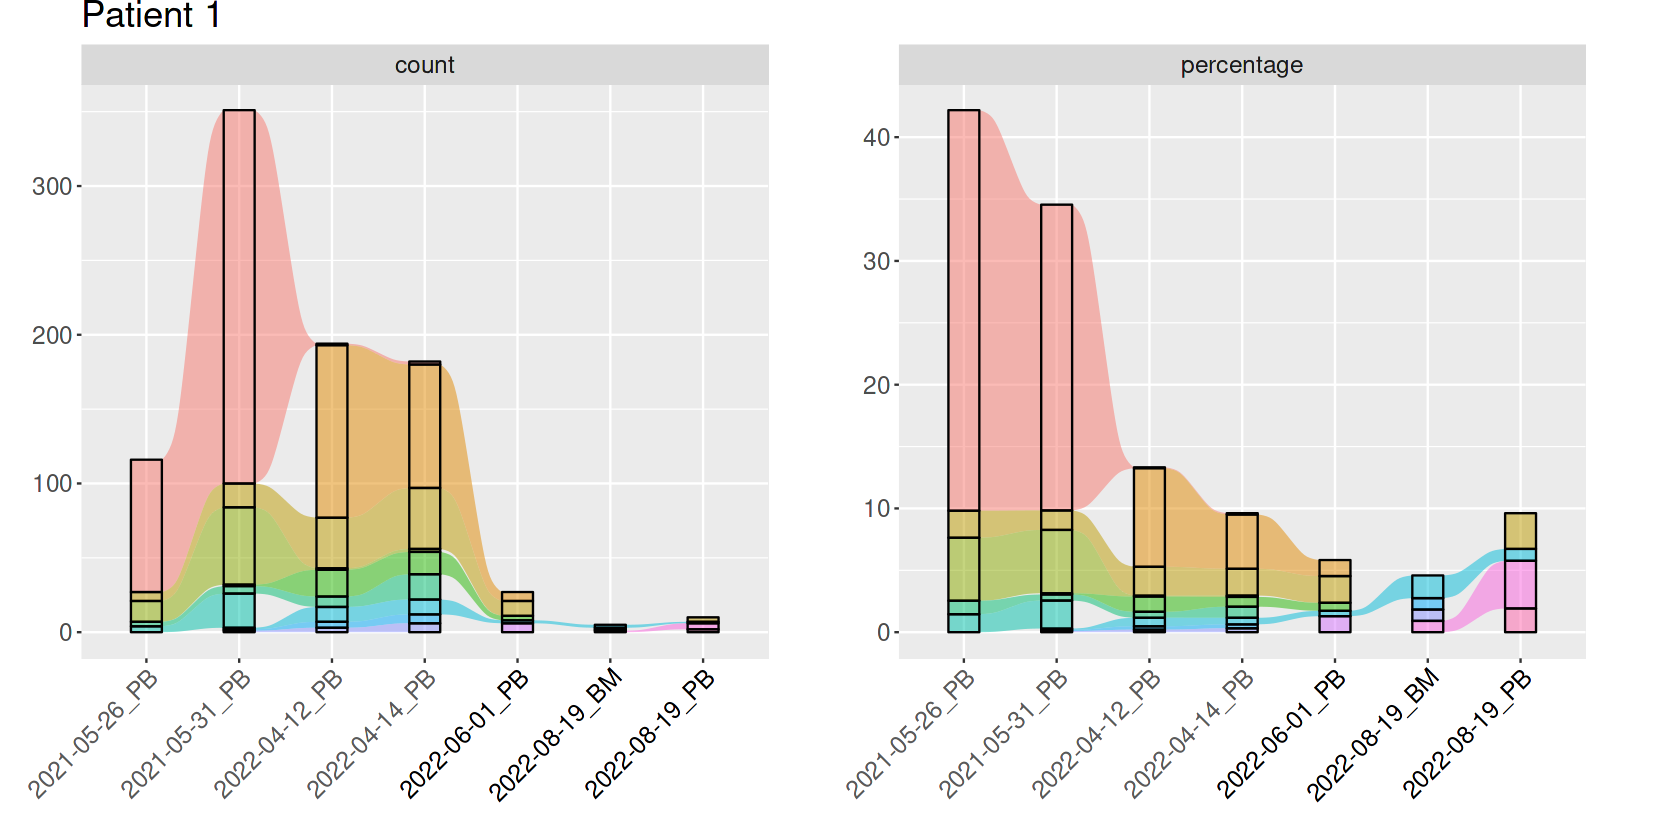

In [21]:
# Figure 6E
options(repr.plot.width=14, repr.plot.height=7, warn=-1)
plotalluvial(cross_proj_1_combined, xaes='day_source', facet_spacing=4, rotate=T)+
  theme(axis.text.x = element_text(color = bold.labels)) 
options(warn=0)

## CAR-T dataset
Here we plot clonotype evolution for the current dataset only. The labels on the X axis is a concatenation of the patient number, days from apharesis, days from infusion and cell source. 

The clonotype id for patient 1 is consistent with the cross-dataset plots above. 

In patient 12, clonotypes 1 and 2 express Ide-cel transcripts. 

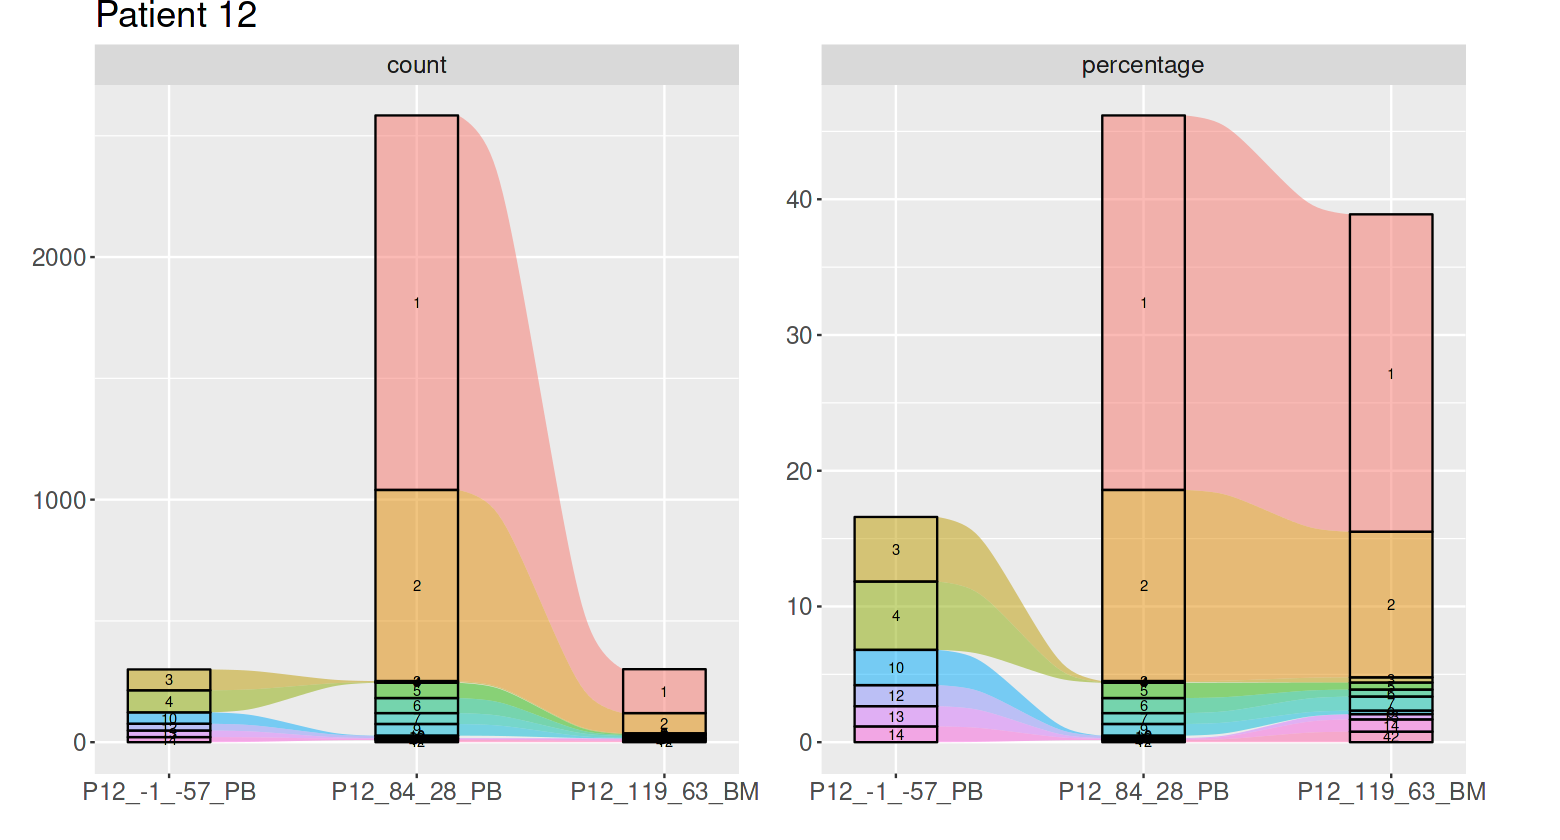

In [319]:
#Figure 6B
options(repr.plot.width=13, repr.plot.height=7)
TCRplot=prepareplot(results_list[[8]])
plotalluvial(TCRplot)

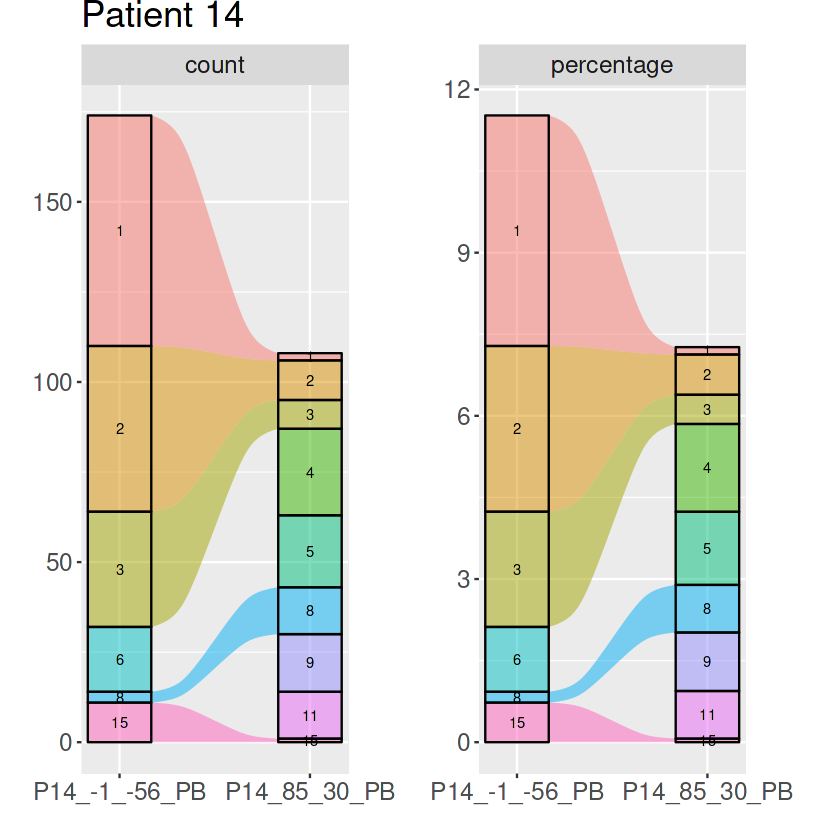

In [321]:
#Figure 6C
options(repr.plot.width=7, repr.plot.height=7)
TCRplot=prepareplot(results_list[[10]])
plotalluvial(TCRplot, facet_spacing=4)

In [4]:
# Check for CAR+ clones
outputfiles=list.files('/mnt/MXMERZ002A/LargeData/enclone/', pattern = 'enclone_output', full.names = T)

In [5]:
seuratobj=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.rds')

In [19]:
TCR_results_pcell=bind_rows(lapply(outputfiles, read_csv, show_col_types = FALSE))

In [7]:
idecel=as.matrix(GetAssayData(seuratobj['idecabtagene', ]))
ciltacel=as.matrix(GetAssayData(seuratobj['ciltacabtagene', ]))

In [13]:
car=cbind(t(ciltacel), t(idecel))
car=car %>% as.data.frame %>% 
bind_cols(sampleid=seuratobj$orig.ident, barcode=str_extract(colnames(seuratobj), '[ATCG]*-1$'), WNN_agg=seuratobj$WNN_agg, patient=seuratobj$patient)
#car=car %>% rownames_to_column('cellbarcode') %>% pivot_longer(ends_with('gene'))

In [ ]:
TCR_results_pcell %>% filter(donors==12, group_id==8)

In [139]:
TCR_results_pcell_CAR=TCR_results_pcell %>% left_join(car, by=c('barcode',origins_cell ='sampleid'))

In [140]:
TCR_results_pcell_CAR=TCR_results_pcell_CAR %>% mutate(idecel_positive=ifelse(idecabtagene>0, 'CAR+','CAR-'))

In [141]:
TCR_results_pcell_CAR=TCR_results_pcell_CAR %>% filter(patient %in% c(12, 14)) %>% count(patient,group_id, idecel_positive)

In [143]:
TCRplot1=TCR_results_pcell_CAR %>% pivot_wider(names_from=idecel_positive, values_from=n, values_fill = 0) %>% 
mutate(group_size=`CAR+`+`CAR-`) %>% pivot_longer(`CAR+`:`CAR-`, values_to='n') %>% mutate(percent=n/group_size*100)

In [144]:
TCRPlot2=TCRplot1 %>% group_by(patient) %>% arrange(-group_size, .by_group = T) %>% slice_head(n=20)

In [145]:
TCRPlot2=TCRPlot2 %>% mutate(patient=paste('Patient', patient)) %>% mutate(group_id=as.factor(group_id)) %>% rename(clonotype='group_id')

Plot of the top 10 largest clones, colored by proportion of CAR+ cells in each clone. A cell is considered CAR+ if there is at least 1 Ide-cel transcript detected. Numbers denote the counts. 

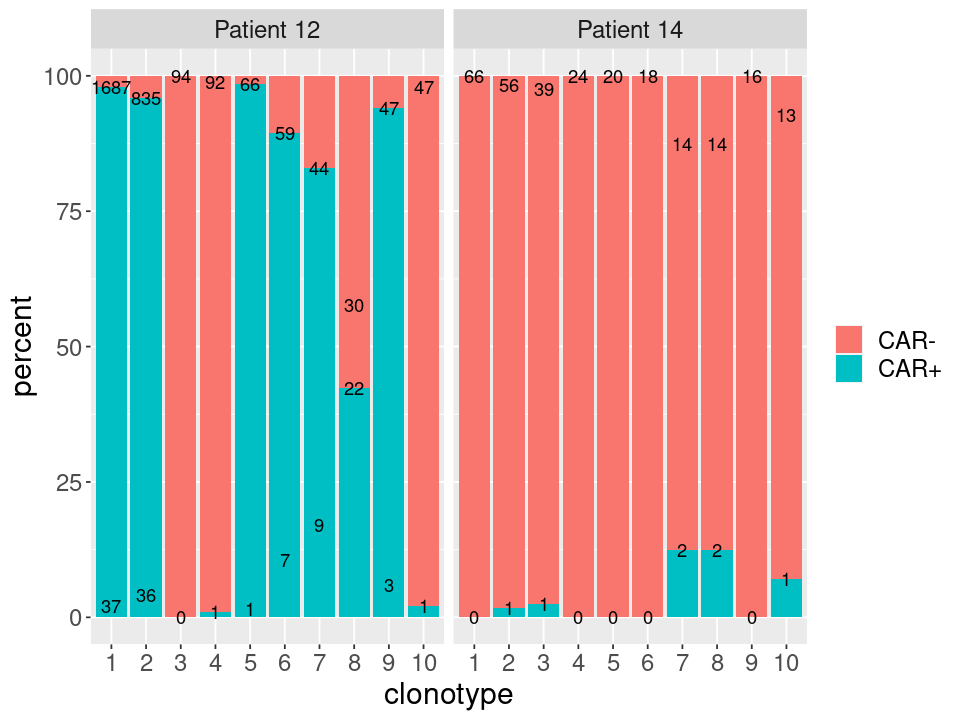

In [147]:
# Figure 6B and C
options(repr.plot.width=8, repr.plot.height=6)
ggplot(TCRPlot2, aes(x=clonotype, y=percent, fill=name, label=n))+
geom_bar(stat='identity')+facet_wrap(~patient)+geom_text()+
theme(text = element_text(size = 18), legend.title=element_blank())

In [37]:
# Prepare Metadata from excel
metadatacsv=read_csv('/mnt/MXMERZ002A/LargeData/seuratobjmetadata.csv', show_col_types = FALSE)

In [38]:
metadatacsv=metadatacsv %>% mutate(response=ifelse(remission.after.CAR=='CR', 'CR', 'nonCR')) %>%
mutate(timepoint=ifelse(days.since.apharesis<2, 'pre','post'))

In [9]:
diversity=function(pop){
 n = pop
 N = sum(pop)
 p = n/N
 H = -sum(p*log(p))
 #H/log(length(pop)) #Normalize
}

In [18]:
TCR_results1_split=TCR_results1 %>% group_by(origins_cell) %>% group_split

In [19]:
getdiversity=function(tcr_i){
diversity_index=diversity(tcr_i$count)
df=data.frame(patient=tcr_i$donors[1], orig.ident=tcr_i$origins_cell[1], diversity=diversity_index)
    }

In [47]:
diversity_df=bind_rows(lapply(TCR_results1_split, getdiversity)) #Get diversity index
diversity_df=diversity_df %>% left_join(metadatacsv %>% select(orig.ident, response, remission.after.CAR, timepoint) %>% distinct, by='orig.ident') # add response

In [ ]:
diversity_df$response=factor(diversity_df$response, levels=c('CR','nonCR'))

In [68]:
diversity_df_baseline_pbmc=diversity_df %>% filter(!grepl('BM$',orig.ident	)) %>% 
filter(timepoint=='pre')

In [22]:
suppressMessages(library(ggpubr))

In [23]:
options(warn=-1)

In [100]:
options(warn=-1)
#Comparison between CR and nonCR
options(repr.plot.width=4, repr.plot.height=7)
p1=ggdotplot(diversity_df_baseline_pbmc, x = 'response', y = 'diversity', xlab='Response', 
             ylab='Shannon Diversity', add = "boxplot",binwidth=0.1, title='PB Premanufacture',
             fill='response', color='response',
             palette=pal_jco(palette = c("default"), alpha = 1)(n=4)[2:1]) + 
stat_compare_means(label.x.npc='center')+ theme(text = element_text(size = 20), legend.position="none")


In [101]:
diversity_df_PI_pbmc=diversity_df %>% filter(!grepl('BM$',orig.ident),orig.ident!='P7_-31_-114_PB')  %>% 
filter(timepoint=='post')

In [102]:
options(repr.plot.width=4, repr.plot.height=7)
p2=ggdotplot(diversity_df_PI_pbmc, x = 'response', y = 'diversity', xlab='Response', 
             ylab='Shannon Diversity', add = "boxplot", binwidth=0.1, title='PB Post infusion',
             fill='response', color='response',
             palette=pal_jco(palette = c("default"), alpha = 1)(n=4)[2:1]) + 
stat_compare_means()+ theme(text = element_text(size = 20), legend.position="none")  

In [103]:
diversity_df_baseline_bm=diversity_df %>% filter(grepl('BM$',orig.ident	))
p3=ggdotplot(diversity_df_baseline_bm, x = 'response', y = 'diversity', xlab='Response', 
             ylab='Shannon Diversity', add = "boxplot",  binwidth=0.05, title='BM Post infusion',
             fill='response', color='response',
             palette=pal_jco(palette = c("default"), alpha = 1)(n=4)[2:1]) + 
stat_compare_means()+ theme(text = element_text(size = 20),legend.position="none")

Shannon diversity of TCR clones. Each circle is a data point. No statistically-significant comparison found. 

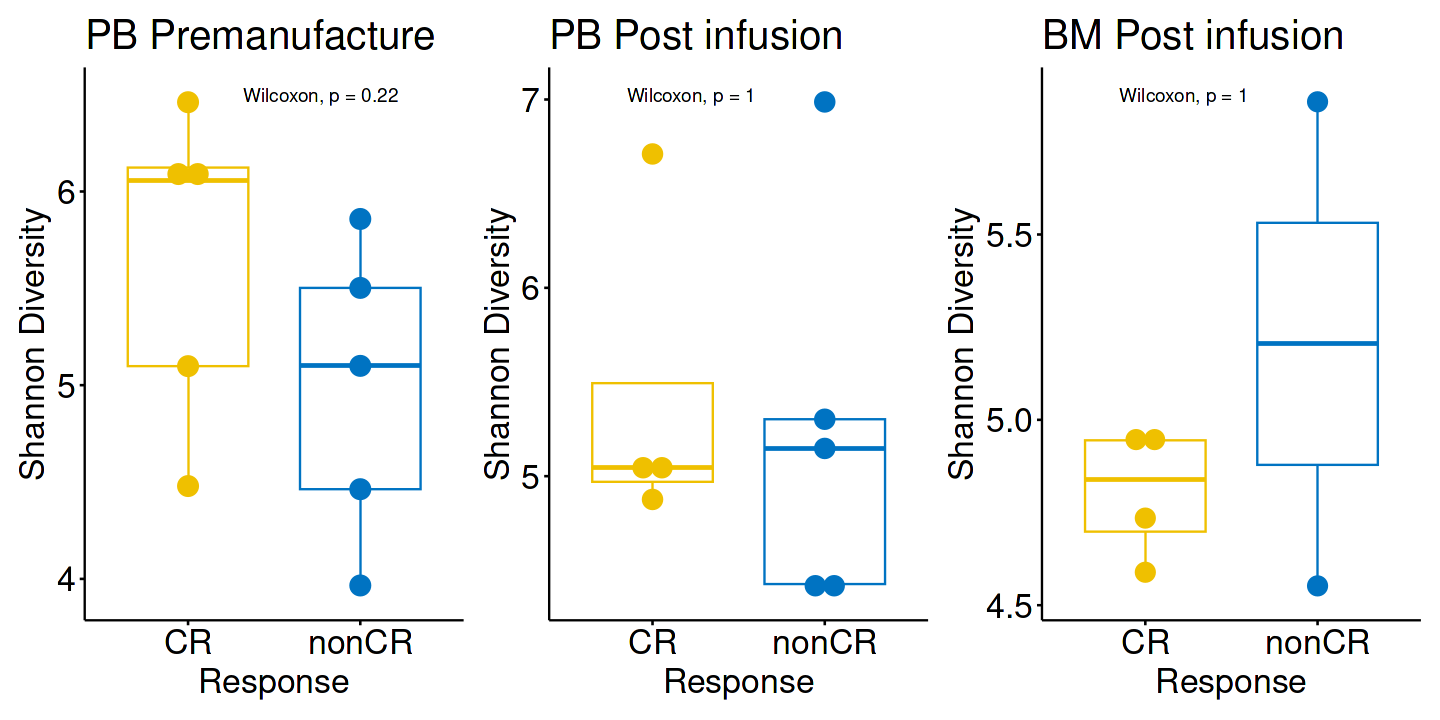

In [104]:
#Figure 6D
options(repr.plot.width=12, repr.plot.height=6)
p1+p2+p3

In [2]:
outputfiles=list.files('/mnt/MXMERZ002A/LargeData/enclone/', pattern = 'enclone_output', full.names = T)
metadatacsv=read_csv('/mnt/MXMERZ002A/LargeData/seuratobjmetadata.csv', show_col_types = FALSE)

In [3]:
TCR_results_pcell=bind_rows(lapply(outputfiles, read_csv, show_col_types = FALSE))

In [4]:
TCR_results_pcell=TCR_results_pcell  %>% add_count(origins_cell, group_id, name='clonotype_size') %>%
left_join(metadatacsv %>% select(orig.ident, remission.after.CAR, days.since.apharesis, source) %>% distinct , by=c(origins_cell='orig.ident' ))

In [5]:
TCR_clonesize=TCR_results_pcell %>% mutate(clonotypesize=ifelse(clonotype_size==1, '1', ifelse(clonotype_size<5, '2-4', '>4'))) %>%
mutate(clonotypesize=factor(clonotypesize, levels=c('1', '2-4', '>4'))) %>%
count(origins_cell, clonotypesize, remission.after.CAR, days.since.apharesis, source) %>% group_by(origins_cell) %>%
mutate(totalcells=sum(n)) %>% mutate(percent=n/totalcells*100)

In [6]:
TCR_clonesizeplot=TCR_clonesize %>% filter(days.since.apharesis<2)

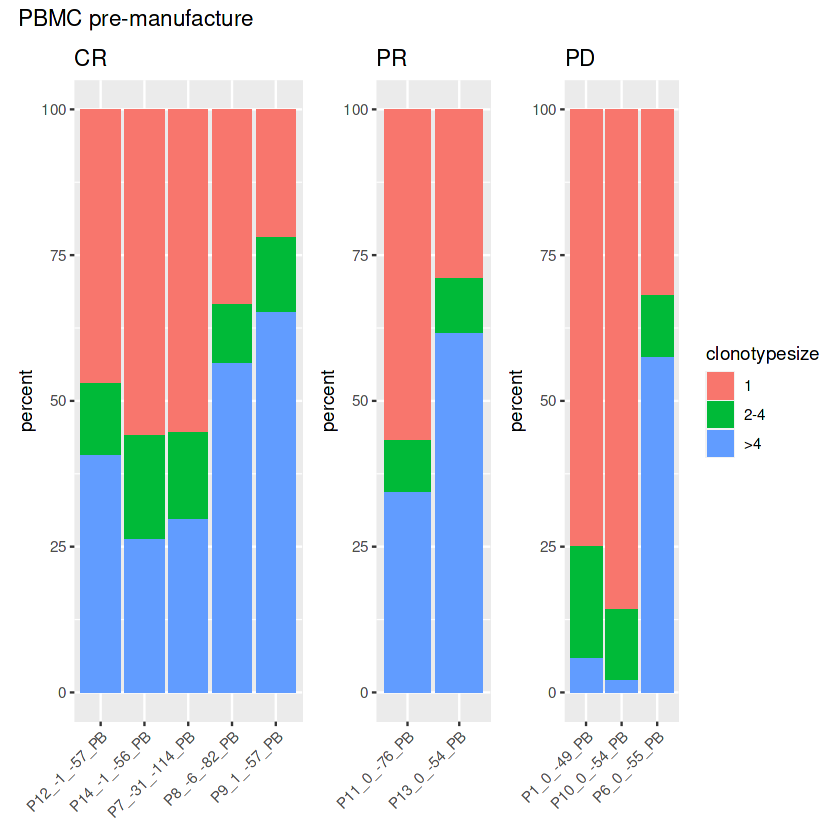

In [7]:
# Figure 6D
p1=ggplot(TCR_clonesizeplot %>% filter(remission.after.CAR=='CR'), aes(x=origins_cell,y=percent, fill=clonotypesize))+geom_bar(stat='identity')+ggtitle('CR')
p2=ggplot(TCR_clonesizeplot %>% filter(remission.after.CAR=='PR'), aes(x=origins_cell,y=percent, fill=clonotypesize))+geom_bar(stat='identity')+ggtitle('PR')
p3=ggplot(TCR_clonesizeplot %>% filter(remission.after.CAR=='PD'), aes(x=origins_cell,y=percent, fill=clonotypesize))+geom_bar(stat='identity')+ggtitle('PD')
p1+p2+p3+plot_layout(widths = c(2, 1, 1), guides = 'collect')+ 
plot_annotation( title = 'PBMC pre-manufacture')& 
theme(axis.title.x=element_blank(), axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))